Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from dataloaders.loaders import load_qqd_data, load_sts17_data


/home/vyro/miniconda3/envs/docSimTrain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-06 17:01:03.303439: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 17:01:03.327973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 17:01:03.734405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

In [2]:
csv_path = '/media/vyro/HDD2/DocSim/BERT/data/sts17/Stsbenchmark/sts-combined.csv'
train = load_sts17_data(csv_path, sep = "\t")
# train.index = np.arange(0, 400)
# train = train.reset_index(drop=True)
print(train.shape)
train.head()

(7673, 3)


/media/vyro/HDD2/DocSim/BERT/dataloaders/loaders.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_duplicate'][df['is_duplicate'] <= thresold] = 1
/media/vyro/HDD2/DocSim/BERT/dataloaders/loaders.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_duplicate'][df['is_duplicate'] > thresold] = 0


,is_duplicate,question1,question2
0,0.0,A plane is taking off.,An air plane is taking off.
1,0.0,A man is playing a large flute.,A man is playing a flute.
2,0.0,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,1.0,Three men are playing chess.,Two men are playing chess.
4,0.0,A man is playing the cello.,A man seated is playing the cello.


In [3]:
print(train.isnull().sum().sum())
train.info()

0
<class 'pandas.core.frame.DataFrame'>
Index: 7673 entries, 0 to 7673
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_duplicate  7673 non-null   float64
 1   question1     7673 non-null   object 
 2   question2     7673 non-null   object 
dtypes: float64(1), object(2)
memory usage: 239.8+ KB


In [4]:
train, test = train_test_split(train, test_size = 0.1, random_state=42, shuffle=True)

In [5]:
train.shape, test.shape

((6905, 3), (768, 3))

In [6]:
train, val = train_test_split(train, test_size = 0.1, random_state=42, shuffle=True)

In [7]:
train.shape, val.shape, test.shape

((6214, 3), (691, 3), (768, 3))

In [8]:
dataset_train = Dataset.from_pandas(train)
dataset_val = Dataset.from_pandas(val)
dataset_test = Dataset.from_pandas(test)

Loading Model

In [9]:
model_checkpoint = "bert-base-cased"
batch_size = 128

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [11]:
tokenizer(train.question1[0], train.question2[0], 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=100,  
                                      return_tensors='tf',return_token_type_ids = True)  # Return torch.Tensor objects


2023-05-06 17:01:05.412562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 17:01:05.442780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 17:01:05.442920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[ 101,  138, 4261, 1110, 1781, 1228,  119,  102, 1760, 1586, 4261,
        1110, 1781, 1228,  119,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0

In [12]:
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length = 75)


In [13]:
pre_tokenizer_columns = set(dataset_train.features)

In [14]:
pre_tokenizer_columns

{'__index_level_0__', 'is_duplicate', 'question1', 'question2'}

In [15]:
encoded_dataset_train = dataset_train.map(preprocess_function, batched=True, )

In [16]:
encoded_dataset_val = dataset_val.map(preprocess_function, batched=True, )

In [17]:
tokenizer_columns = list(set(encoded_dataset_train.features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['attention_mask', 'input_ids', 'token_type_ids']


In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)

tf_train_dataset = encoded_dataset_train.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = encoded_dataset_val.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

/home/vyro/miniconda3/envs/docSimTrain/lib/python3.11/site-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [19]:
z = next(iter(tf_train_dataset))
tokenizer.decode(z[0]['input_ids'][0])

2023-05-06 17:01:06.426269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [6214]
	 [[{{node Placeholder/_0}}]]
2023-05-06 17:01:06.426403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [6214]
	 [[{{node Placeholder/_0}}]]


"[CLS] Every Thursday, a grains management committee meets in the Commission's agriculture directorate to decide the outcome of a weekly export tender. [SEP] A grains management committee normally meets each Thursday in the Commission's agriculture unit - - another target of Wednesday's raids - - to decide the outcome of a weekly export tender. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [20]:
# Number of classes in the classification task
num_labels = train.is_duplicate.nunique()
num_labels

2

#LOADING MODEL

In [21]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels)

2023-05-06 17:01:08.280121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

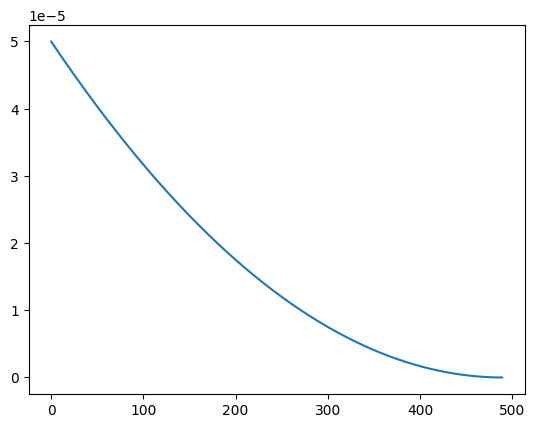

In [23]:
lr_schedule = []
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr_schedule.append(lr_scheduler.initial_learning_rate * decay)

plt.plot(lr_schedule)


In [24]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [25]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

Epoch 1/10


2023-05-06 17:01:19.689047: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x561fac20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-06 17:01:19.689064: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA Graphics Device, Compute Capability 8.6
2023-05-06 17:01:19.692741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-06 17:01:19.788733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-06 17:01:19.852172: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.7549

2023-05-06 17:01:47.231614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [691]
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 40s 411ms/step - loss: 0.4918 - accuracy: 0.7549 - val_loss: 0.3778 - val_accuracy: 0.8480
Epoch 2/10
49/49 [==============================] - 19s 378ms/step - loss: 0.2735 - accuracy: 0.8928 - val_loss: 0.3820 - val_accuracy: 0.8394
Epoch 3/10
49/49 [==============================] - 19s 381ms/step - loss: 0.1506 - accuracy: 0.9487 - val_loss: 0.4457 - val_accuracy: 0.8379
Epoch 4/10
49/49 [==============================] - 19s 383ms/step - loss: 0.0795 - accuracy: 0.9776 - val_loss: 0.5144 - val_accuracy: 0.8350
Epoch 5/10
49/49 [==============================] - 19s 382ms/step - loss: 0.0466 - accuracy: 0.9876 - val_loss: 0.5818 - val_accuracy: 0.8394
Epoch 6/10
49/49 [==============================] - 19s 383ms/step - loss: 0.0314 - accuracy: 0.9924 - val_loss: 0.6030 - val_accuracy: 0.8336
Epoch 7/10
49/49 [==============================] - 19s 383ms/step - loss: 0.0222 - accuracy: 0.9947 - val_loss: 0.6191 - val_accuracy: 0.8423
Epoch 8/10

In [26]:
save_path = 'runs/sts/model'
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)

In [27]:
encoded_dataset_test = dataset_test.map(preprocess_function, batched=True, )

In [28]:
tf_test_dataset = encoded_dataset_test.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [29]:
model.evaluate(tf_test_dataset)

2023-05-06 17:04:38.290667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [768]
	 [[{{node Placeholder/_0}}]]


6/6 [==============================] - 1s 137ms/step - loss: 0.6278 - accuracy: 0.8529


[0.6278019547462463, 0.8528645634651184]